In [1]:
import cv2

import torch
import torch.nn as nn
import torchvision

import matplotlib.pyplot as plt
%matplotlib inline

# Retinaface

In [2]:
import cv2
import numpy as np

import torch
import torch.nn as nn
import torchvision

import matplotlib.pyplot as plt
%matplotlib inline

im = cv2.imread('data/tests/choir.jpg')

In [3]:
from inference import Inference

net = Inference('retinaface_tmp/weights/mobilenet0.25_Final.pth',
                'mobile0.25', use_cpu=True)

new_width = 1280
new_height = 720
im = cv2.resize(im, (new_width, new_height))
# boxes, scores, landmarks = net(im)

Loading pretrained model from retinaface_tmp/weights/mobilenet0.25_Final.pth
remove prefix 'module.'
Missing keys:0
Unused checkpoint keys:0
Used keys:300
Finished loading model!
RetinaFace(
  (body): IntermediateLayerGetter(
    (stage1): Sequential(
      (0): Sequential(
        (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.1, inplace=True)
      )
      (1): Sequential(
        (0): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=8, bias=False)
        (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.1, inplace=True)
        (3): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): LeakyReLU(negative_slope=0.1

In [3]:
%time
boxes, scores, landmarks = net(im)

CPU times: user 9 µs, sys: 3 µs, total: 12 µs
Wall time: 22.2 µs


In [3]:
FONTFACE = cv2.FONT_HERSHEY_SIMPLEX
FONT_SCALE = 0.7
THICKNESS = 1

def display_text(im, text, x, y):

    textSize = cv2.getTextSize(text, FONTFACE, FONT_SCALE, THICKNESS)
    dim = textSize[0]
    baseline = textSize[1]
               
    # cv2.rectangle(im, (x,y-dim[1] - baseline), (x + dim[0], y + baseline), (0,0,0), cv2.FILLED);
    cv2.putText(im, text, (x, y-5), FONTFACE, FONT_SCALE, (0, 255, 255), THICKNESS, cv2.LINE_AA)

def display_objects(im, objects, threshold=0.25):

    rows = im.shape[0]; cols = im.shape[1]
    boxes, scores = objects
    for i in range(len(boxes)):
        score = scores[i]
        box = boxes[i]
        # display_text(im, "{:.02f}".format(score), box[0], box[1])
        cv2.rectangle(im, (box[0], box[1]), (box[2], box[3]), (255, 255, 255), 2)

    mp_img = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(15, 15)); plt.imshow(mp_img); plt.show();

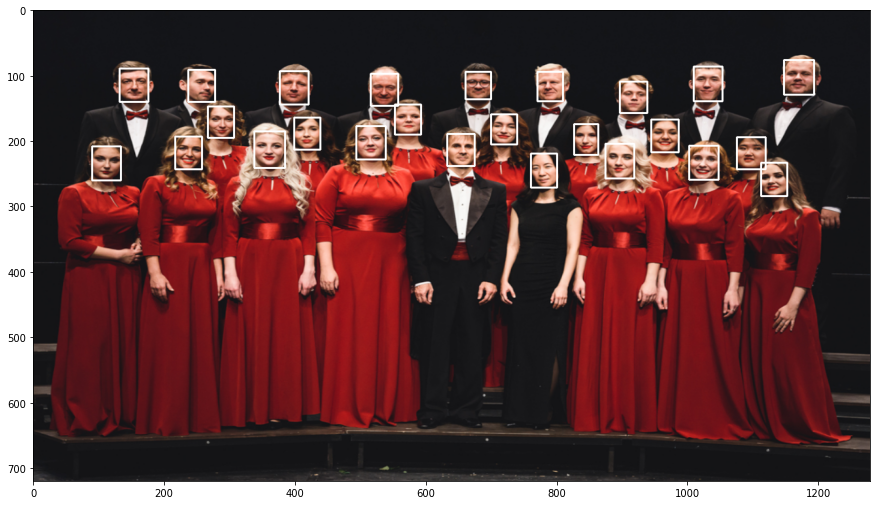

In [4]:
display_objects(im, (boxes, scores))

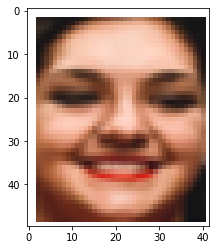

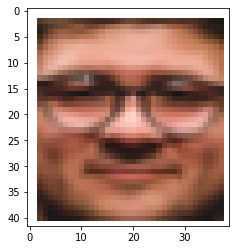

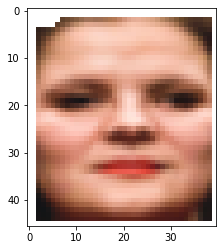

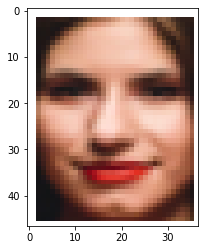

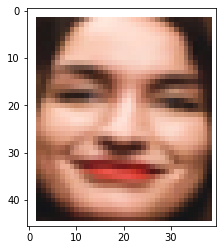

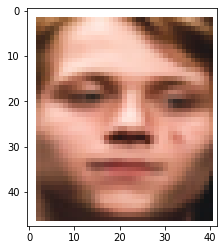

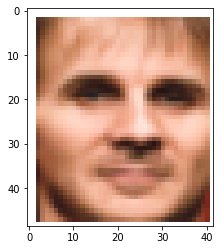

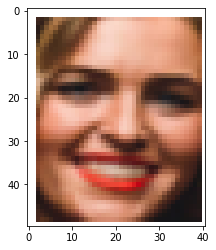

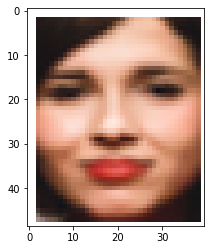

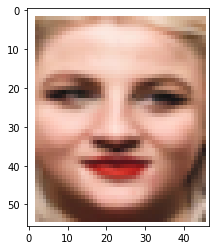

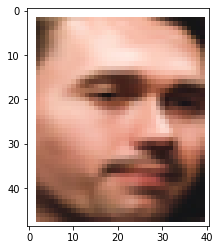

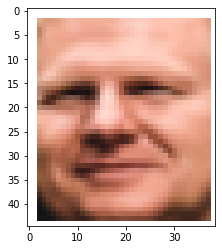

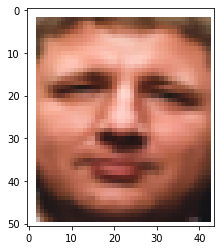

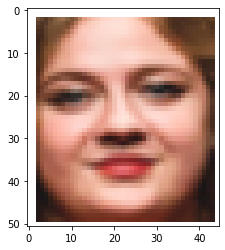

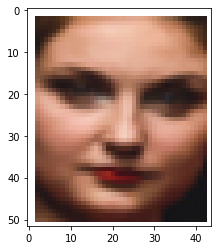

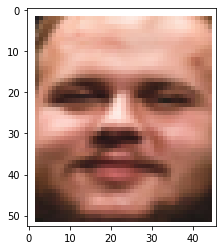

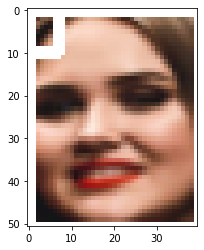

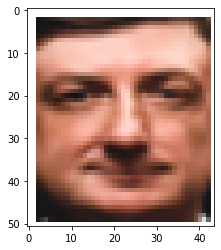

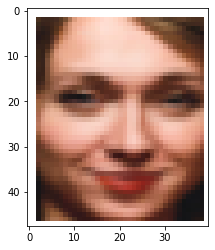

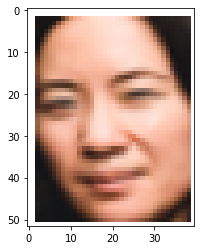

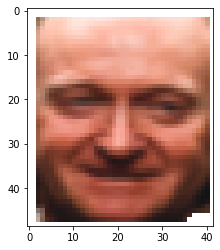

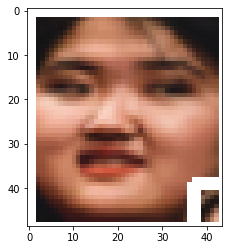

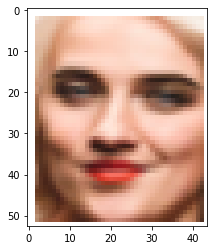

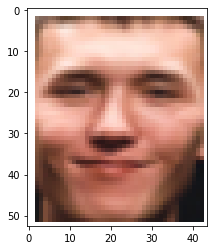

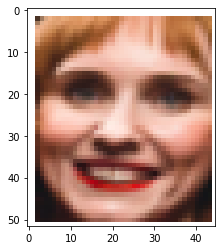

In [5]:
prepr = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Resize((224, 224)),
    torchvision.transforms.Normalize(mean=[0.5, 0.5, 0.5],
                                     std=[0.5, 0.5, 0.5])
])

faces = torch.zeros(len(boxes), 3, 224, 224)
for i, box in enumerate(boxes):
    face = im[box[1]:box[3], box[0]:box[2]]
    faces[i] = prepr(face)
    plt.imshow(face[:, :, ::-1]); plt.show();

In [6]:
class AffectNN(nn.Module):
    def __init__(self):
        super(AffectNN, self).__init__()
        
        cnn = torchvision.models.resnet18(pretrained=True)
        self.conv = nn.Sequential(
            *list(cnn.children())[:-1],
            nn.Flatten()
        )
        self.fc = nn.Sequential(
            nn.Linear(512, 8),
            nn.Softmax(dim=-1),
        )
    def forward(self, x):
        out = self.conv(x)
        out = self.fc(out)
        return out
    
fer = AffectNN()

pred = fer(faces)

/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [7]:
emotions = {
    0:'neutral',
    1:'happy',
    2:'sad',
    3:'surpise',
    4:'fear',
    5:'distgust',
    6:'angry',
    7:'contempt'
}

aff_pred = torch.argmax(pred, dim=-1).tolist()

In [8]:
FONTFACE = cv2.FONT_HERSHEY_SIMPLEX
FONT_SCALE = 0.7
THICKNESS = 1

def display_text(im, text, x, y):

    textSize = cv2.getTextSize(text, FONTFACE, FONT_SCALE, THICKNESS)
    dim = textSize[0]
    baseline = textSize[1]
               
    # cv2.rectangle(im, (x,y-dim[1] - baseline), (x + dim[0], y + baseline), (0,0,0), cv2.FILLED);
    cv2.putText(im, text, (x, y-5), FONTFACE, FONT_SCALE, (0, 255, 255), THICKNESS, cv2.LINE_AA)

def display_objects(im, objects, aff_pred):

    rows = im.shape[0]; cols = im.shape[1]
    boxes, scores = objects
    for i in range(len(boxes)):
        box = boxes[i]
        display_text(im, "{}".format(emotions[aff_pred[i]]), box[0], box[1])
        cv2.rectangle(im, (box[0], box[1]), (box[2], box[3]), (255, 255, 255), 2)

    mp_img = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(15, 15)); plt.imshow(mp_img); plt.show();

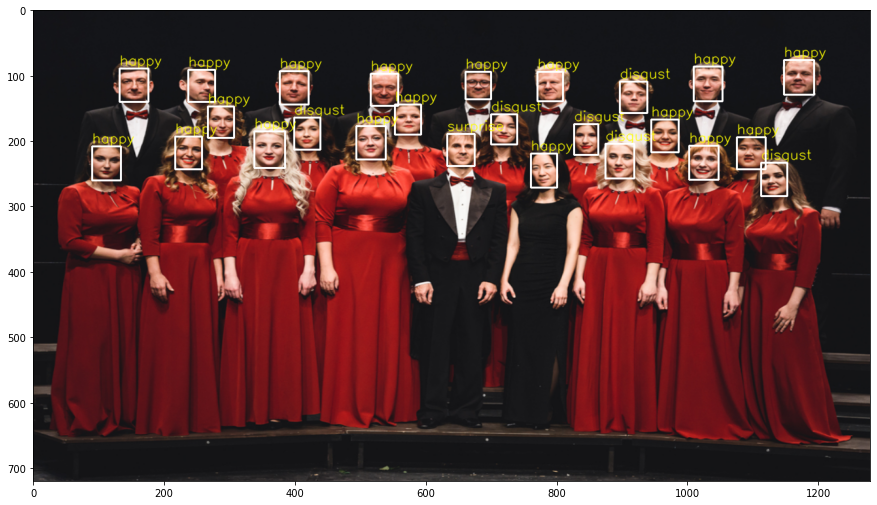

In [9]:
display_objects(im, (boxes, scores), aff_pred)

# End-to-end AffectNN

In [1]:
import cv2
import numpy as np

import torch
import torch.nn as nn
import torchvision

import matplotlib.pyplot as plt
%matplotlib inline

im = cv2.imread('data/tests/choir.jpg')

In [2]:
FONTFACE = cv2.FONT_HERSHEY_SIMPLEX
FONT_SCALE = 0.7
THICKNESS = 1

def display_text(im, text, x, y):

    textSize = cv2.getTextSize(text, FONTFACE, FONT_SCALE, THICKNESS)
    dim = textSize[0]
    baseline = textSize[1]
               
    # cv2.rectangle(im, (x,y-dim[1] - baseline), (x + dim[0], y + baseline), (0,0,0), cv2.FILLED);
    cv2.putText(im, text, (x, y-5), FONTFACE, FONT_SCALE, (0, 255, 255), THICKNESS, cv2.LINE_AA)

def display_objects(im, boxes, aff_pred):

    rows = im.shape[0]; cols = im.shape[1]
    for i in range(len(boxes)):
        box = boxes[i]
        display_text(im, "{}".format(emotions[aff_pred[i]]), box[0], box[1])
        cv2.rectangle(im, (box[0], box[1]), (box[2], box[3]), (255, 255, 255), 2)

    mp_img = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(15, 15)); plt.imshow(mp_img); plt.show();

In [44]:
from inference import Inference
prepr = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Resize((224, 224)),
    torchvision.transforms.Normalize(mean=[0.5, 0.5, 0.5],
                                     std=[0.5, 0.5, 0.5])
])

emotions = {
    0:'neutral',
    1:'happy',
    2:'sad',
    3:'surpise',
    4:'fear',
    5:'distgust',
    6:'angry',
    7:'contempt'
}

class AffectNN(nn.Module):
    def __init__(self):
        super(AffectNN, self).__init__()
        
        self.detect = Inference('graphs/mobilenet0.25_Final.pth',
                                'mobile0.25', use_cpu=True)
        
        cnn = torchvision.models.resnet18(pretrained=True)
        self.conv = nn.Sequential(
            *list(cnn.children())[:-1],
        )
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512, 8),
            nn.Softmax(dim=-1),
        )
        self.classif = nn.Sequential(
            self.conv,
            self.fc
        )
        
    def forward(self, x):
        new_width = 1280
        new_height = 720
        x = cv2.resize(x, (new_width, new_height))
        boxes, scores, landmarks = self.detect(x)
        
        faces = torch.zeros(len(boxes), 3, 224, 224)
        for i, box in enumerate(boxes):
            face = x[box[1]:box[3], box[0]:box[2]]
            faces[i] = prepr(face)
            
        affects = self.classif(faces)
        return boxes, affects
    
fer = AffectNN()

Loading pretrained model from graphs/mobilenet0.25_Final.pth
remove prefix 'module.'
Missing keys:0
Unused checkpoint keys:0
Used keys:300
Finished loading model!
RetinaFace(
  (body): IntermediateLayerGetter(
    (stage1): Sequential(
      (0): Sequential(
        (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.1, inplace=True)
      )
      (1): Sequential(
        (0): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=8, bias=False)
        (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.1, inplace=True)
        (3): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): LeakyReLU(negative_slope=0.1, inplace=True)


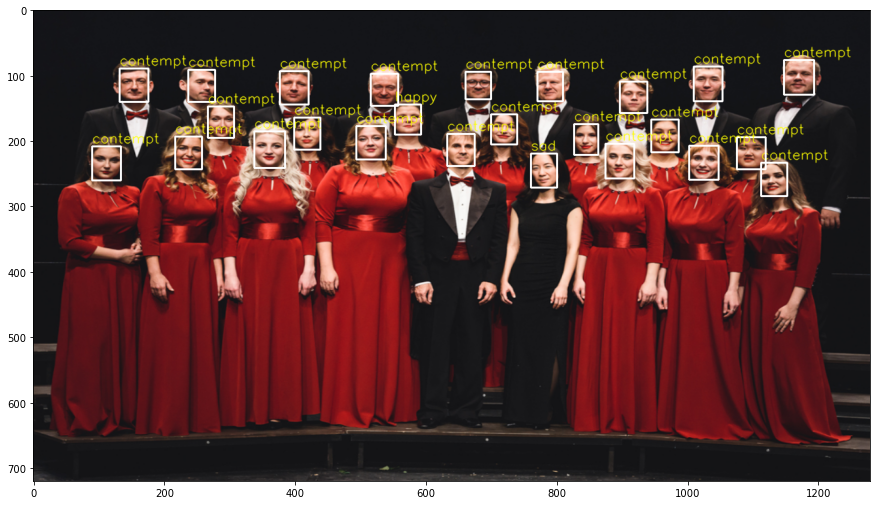

CPU times: user 3.15 s, sys: 1.67 s, total: 4.81 s
Wall time: 969 ms


In [46]:
%%time
# im = pack[17][0]
im = cv2.imread('data/tests/choir.jpg')
pred = fer(im)

new_width = 1280
new_height = 720
im = cv2.resize(im, (new_width, new_height))
display_objects(im, pred[0], torch.argmax(pred[1], dim=-1).tolist())

# Classifier

## Train

In [4]:
import pickle as pkl
with open('data/affectnet/train/0', 'rb') as f:
    pack = pkl.load(f)
    
# pack

In [11]:
# cnn = torchvision.models.mobilenet_v2(pretrained=True)
cnn = torchvision.models.resnet18(pretrained=True)
conv = nn.Sequential(*list(cnn.children())[:-1])
fc = nn.Sequential(
    nn.Flatten(),
    nn.Linear(512, 8),
    nn.Softmax(dim=-1)
)

In [26]:
classifier = nn.Sequential(
    conv,
    fc
)

class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        
        self.net = nn.Sequential(
            conv,
            fc
        )
        
    def forward(self, x):
        new_width = 84
        new_height = 84
        
        inp = torch.zeros(len(x), 3, 84, 84)
        for i, im in enumerate(x):
            im = cv2.resize(im, (new_width, new_height))
            inp[i] = prepr(im)
            
        return self.net(inp)
    
classif = Classifier()
classif([pack[0][0], pack[1][0]])

tensor([[0.1232, 0.1325, 0.1281, 0.1212, 0.1260, 0.1232, 0.1221, 0.1237],
        [0.1242, 0.1305, 0.1283, 0.1160, 0.1265, 0.1243, 0.1236, 0.1266]],
       grad_fn=<SoftmaxBackward>)

In [28]:
classif = nn.Sequential(
    conv,
    fc
)

In [20]:
from torch.utils.data import DataLoader

prepr = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Resize((224, 224)),
    torchvision.transforms.Normalize(mean=[0.5, 0.5, 0.5],
                                     std=[0.5, 0.5, 0.5])
])

cuda = torch.device('cuda')

def gen_batch(bdata):
    new_width = 224
    new_height = 224
    inp = torch.zeros(len(bdata), 3, 224, 224)
    labels = torch.zeros(len(bdata), dtype=torch.long)
    for i, (im, label) in enumerate(bdata):
        im = cv2.resize(im, (new_width, new_height))
        inp[i] = prepr(im)
        labels[i] = label
    return inp.to(cuda), labels.to(cuda)

dloader = DataLoader(pack, batch_size=16, shuffle=True, collate_fn=gen_batch)

In [51]:
optimizer = torch.optim.Adam(classif.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()
classif = classif.to(cuda)

for epoch in range(20):
    for p_num in range(17):
        with open('data/affectnet/train/' + str(p_num), 'rb') as f:
            pack = pkl.load(f)
        dloader = DataLoader(pack, batch_size=512, shuffle=True, collate_fn=gen_batch)
        
        for i, (x, labels) in enumerate(dloader):
            pred = classif(x)

            optimizer.zero_grad()
            loss = criterion(pred, labels)
            loss.backward()
            optimizer.step()

            print('Epoch {} Pack {} Loss {}'.format(epoch, 
                                                    p_num, 
                                                    loss.item()))

Epoch 0 Pack 0 Loss 1.3403983116149902
Epoch 0 Pack 0 Loss 1.3393856287002563
Epoch 0 Pack 1 Loss 1.315179467201233
Epoch 0 Pack 1 Loss 1.3390637636184692
Epoch 0 Pack 2 Loss 1.3437143564224243
Epoch 0 Pack 2 Loss 1.3276516199111938
Epoch 0 Pack 3 Loss 1.3167587518692017
Epoch 0 Pack 3 Loss 1.317355990409851
Epoch 0 Pack 4 Loss 1.32256019115448
Epoch 0 Pack 4 Loss 1.3328344821929932
Epoch 0 Pack 5 Loss 1.3343737125396729
Epoch 0 Pack 5 Loss 1.3553928136825562
Epoch 0 Pack 6 Loss 1.3187600374221802
Epoch 0 Pack 6 Loss 1.3251091241836548
Epoch 0 Pack 7 Loss 1.3424209356307983
Epoch 0 Pack 7 Loss 1.3281575441360474
Epoch 0 Pack 8 Loss 1.3304117918014526
Epoch 0 Pack 8 Loss 1.331155776977539
Epoch 0 Pack 9 Loss 1.3401957750320435
Epoch 0 Pack 9 Loss 1.3313195705413818
Epoch 0 Pack 10 Loss 1.3329277038574219
Epoch 0 Pack 10 Loss 1.3313735723495483
Epoch 0 Pack 11 Loss 1.3401930332183838
Epoch 0 Pack 11 Loss 1.335740089416504
Epoch 0 Pack 12 Loss 1.3246116638183594
Epoch 0 Pack 12 Loss 1.335

Epoch 6 Pack 3 Loss 1.3137140274047852
Epoch 6 Pack 3 Loss 1.3180776834487915
Epoch 6 Pack 4 Loss 1.3344056606292725
Epoch 6 Pack 4 Loss 1.3150137662887573
Epoch 6 Pack 5 Loss 1.3489015102386475
Epoch 6 Pack 5 Loss 1.3376356363296509
Epoch 6 Pack 6 Loss 1.330261468887329
Epoch 6 Pack 6 Loss 1.3128681182861328
Epoch 6 Pack 7 Loss 1.320393681526184
Epoch 6 Pack 7 Loss 1.3437494039535522
Epoch 6 Pack 8 Loss 1.3313679695129395
Epoch 6 Pack 8 Loss 1.3273003101348877
Epoch 6 Pack 9 Loss 1.3302488327026367
Epoch 6 Pack 9 Loss 1.3370726108551025
Epoch 6 Pack 10 Loss 1.3427910804748535
Epoch 6 Pack 10 Loss 1.319873332977295
Epoch 6 Pack 11 Loss 1.3367149829864502
Epoch 6 Pack 11 Loss 1.3376483917236328
Epoch 6 Pack 12 Loss 1.3268847465515137
Epoch 6 Pack 12 Loss 1.3315383195877075
Epoch 6 Pack 13 Loss 1.337029218673706
Epoch 6 Pack 13 Loss 1.3344464302062988
Epoch 6 Pack 14 Loss 1.3461092710494995
Epoch 6 Pack 14 Loss 1.3722256422042847
Epoch 6 Pack 15 Loss 1.3514448404312134
Epoch 6 Pack 15 Lo

Epoch 12 Pack 5 Loss 1.3456461429595947
Epoch 12 Pack 5 Loss 1.3372060060501099
Epoch 12 Pack 6 Loss 1.3232510089874268
Epoch 12 Pack 6 Loss 1.3159213066101074
Epoch 12 Pack 7 Loss 1.3346127271652222
Epoch 12 Pack 7 Loss 1.3244481086730957
Epoch 12 Pack 8 Loss 1.3148356676101685
Epoch 12 Pack 8 Loss 1.3437321186065674
Epoch 12 Pack 9 Loss 1.314880132675171
Epoch 12 Pack 9 Loss 1.3476641178131104
Epoch 12 Pack 10 Loss 1.3344395160675049
Epoch 12 Pack 10 Loss 1.3254581689834595
Epoch 12 Pack 11 Loss 1.3441829681396484
Epoch 12 Pack 11 Loss 1.3268613815307617
Epoch 12 Pack 12 Loss 1.3152357339859009
Epoch 12 Pack 12 Loss 1.3371031284332275
Epoch 12 Pack 13 Loss 1.3325116634368896
Epoch 12 Pack 13 Loss 1.3393326997756958
Epoch 12 Pack 14 Loss 1.3397787809371948
Epoch 12 Pack 14 Loss 1.3612561225891113
Epoch 12 Pack 15 Loss 1.3225014209747314
Epoch 12 Pack 15 Loss 1.3572721481323242
Epoch 12 Pack 16 Loss 1.3350811004638672
Epoch 12 Pack 16 Loss 1.3413034677505493
Epoch 13 Pack 0 Loss 1.3344

Epoch 18 Pack 5 Loss 1.3514333963394165
Epoch 18 Pack 5 Loss 1.3269808292388916
Epoch 18 Pack 6 Loss 1.3169840574264526
Epoch 18 Pack 6 Loss 1.31441330909729
Epoch 18 Pack 7 Loss 1.3306463956832886
Epoch 18 Pack 7 Loss 1.3230074644088745
Epoch 18 Pack 8 Loss 1.3107680082321167
Epoch 18 Pack 8 Loss 1.3413177728652954
Epoch 18 Pack 9 Loss 1.3222674131393433
Epoch 18 Pack 9 Loss 1.3351496458053589
Epoch 18 Pack 10 Loss 1.325864553451538
Epoch 18 Pack 10 Loss 1.3310176134109497
Epoch 18 Pack 11 Loss 1.3382594585418701
Epoch 18 Pack 11 Loss 1.32895827293396
Epoch 18 Pack 12 Loss 1.3261746168136597
Epoch 18 Pack 12 Loss 1.320919394493103
Epoch 18 Pack 13 Loss 1.3244187831878662
Epoch 18 Pack 13 Loss 1.3434233665466309
Epoch 18 Pack 14 Loss 1.339560627937317
Epoch 18 Pack 14 Loss 1.3554004430770874
Epoch 18 Pack 15 Loss 1.3183550834655762
Epoch 18 Pack 15 Loss 1.3551520109176636
Epoch 18 Pack 16 Loss 1.3363354206085205
Epoch 18 Pack 16 Loss 1.3325964212417603
Epoch 19 Pack 0 Loss 1.3343005180

In [53]:
torch.save(classif.state_dict(), 'graphs/resnet18')

## Validation

In [52]:
hits = 0
total = 0
for p_num in range(3):
    with open('data/affectnet/val/' + str(p_num), 'rb') as f:
        pack = pkl.load(f)
    dloader = DataLoader(pack, batch_size=64, collate_fn=gen_batch)
    
    for i, (x, labels) in enumerate(dloader):
        pred = classif(x)
        
        pr_labels = torch.argmax(pred.detach(), dim=-1)
        hits += (labels == torch.argmax(pred, dim=-1)).sum()
        total += labels.shape[0]
        
print('Accuracy = {}'.format(hits / total))

Accuracy = 0.503000020980835


# Load classifier to AffectNN

In [3]:
from dan.dan import DAN

In [21]:
from inference import Inference
prepr = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Resize((224, 224)),
    torchvision.transforms.Normalize(mean=[0.5, 0.5, 0.5],
                                     std=[0.5, 0.5, 0.5])
])

emotions = {
    0:'neutral',
    1:'happy',
    2:'sad',
    3:'surpise',
    4:'fear',
    5:'distgust',
    6:'angry',
    7:'contempt'
}

class AffectNN(nn.Module):
    def __init__(self):
        super(AffectNN, self).__init__()
        
        self.detect = Inference('models/mobilenet0.25_Final.pth',
                                'mobile0.25', use_cpu=True)
        self.classif = DAN(num_class=8)
        
    def forward(self, x):
        new_width = 1280
        new_height = 720
        x = cv2.resize(x, (new_width, new_height))
        boxes, scores, landmarks = self.detect(x)
        
        faces = torch.zeros(len(boxes), 3, 224, 224)
        for i, box in enumerate(boxes):
            face = x[box[1]:box[3], box[0]:box[2]]
            faces[i] = prepr(face)
            
        affects = self.classif(faces)
        return boxes, affects[0]
    
fer = AffectNN()

Loading pretrained model from models/mobilenet0.25_Final.pth
remove prefix 'module.'
Missing keys:0
Unused checkpoint keys:0
Used keys:300
Finished loading model!
RetinaFace(
  (body): IntermediateLayerGetter(
    (stage1): Sequential(
      (0): Sequential(
        (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.1, inplace=True)
      )
      (1): Sequential(
        (0): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=8, bias=False)
        (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.1, inplace=True)
        (3): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): LeakyReLU(negative_slope=0.1, inplace=True)


In [22]:
verb_dict = torch.load('models/dan', map_location=torch.device('cpu'))

fer.classif.load_state_dict(verb_dict['model_state_dict'])

<All keys matched successfully>

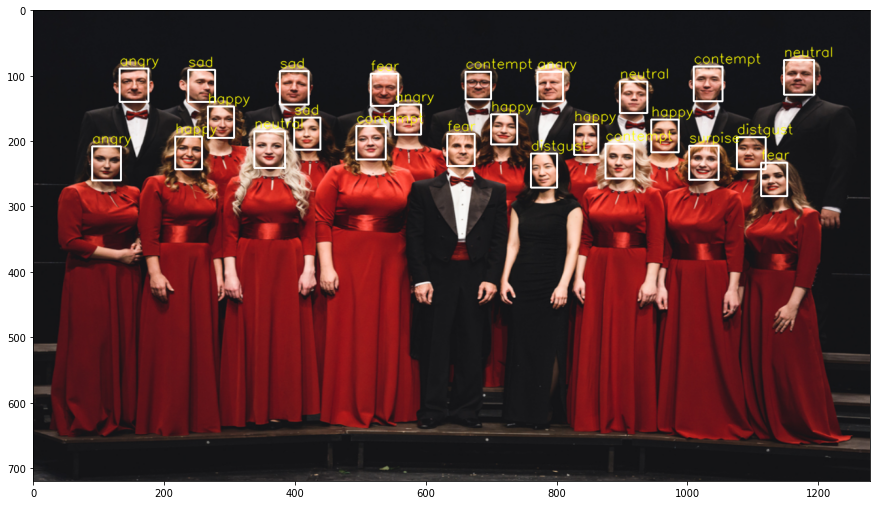

CPU times: user 11.8 s, sys: 3.11 s, total: 15 s
Wall time: 35.5 s


In [23]:
%%time
# im = pack[17][0]
im = cv2.imread('data/tests/choir.jpg')
pred = fer(im)

new_width = 1280
new_height = 720
im = cv2.resize(im, (new_width, new_height))
display_objects(im, pred[0], torch.argmax(pred[1], dim=-1).tolist())

In [16]:
tmp = torch.randn(10, 3, 224, 224)
out = fer.classif(tmp)

In [20]:
out[0].shape

torch.Size([10, 4, 512])